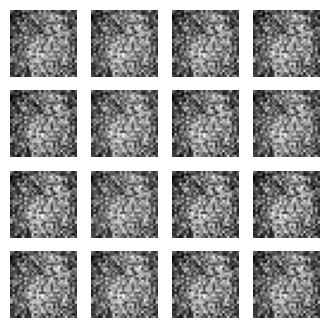

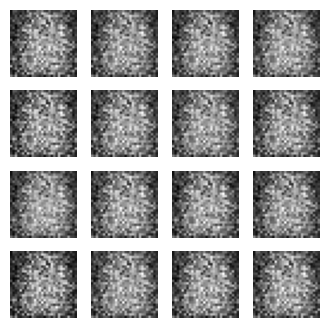

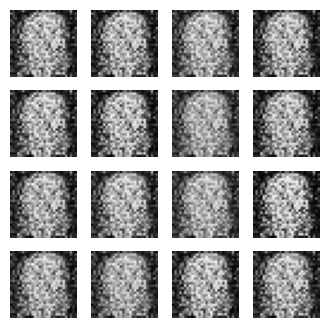

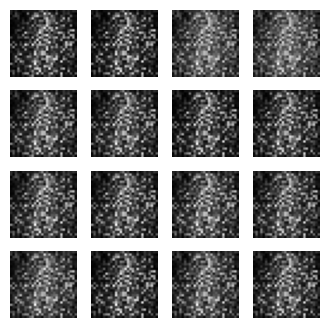

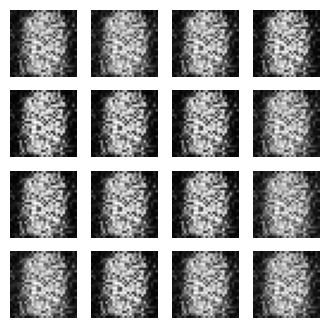

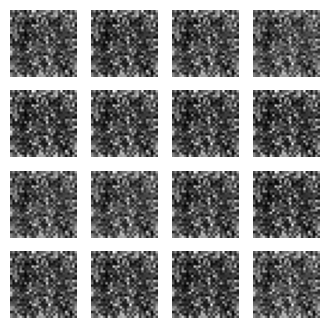

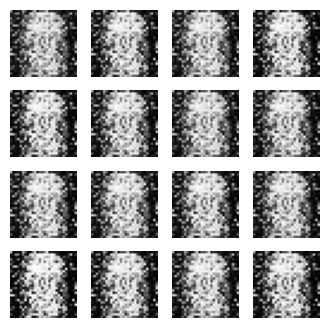

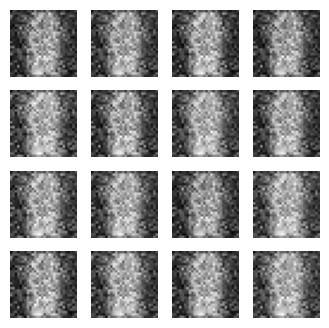

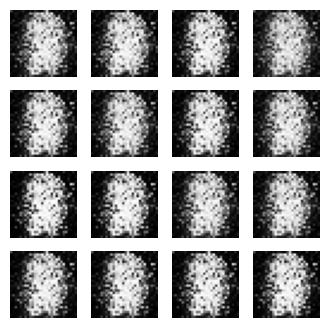

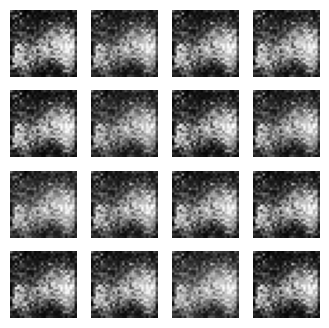

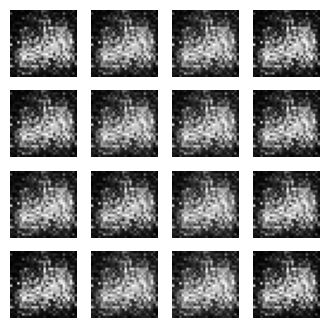

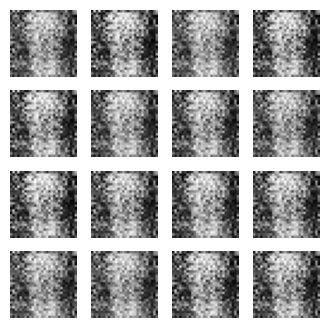

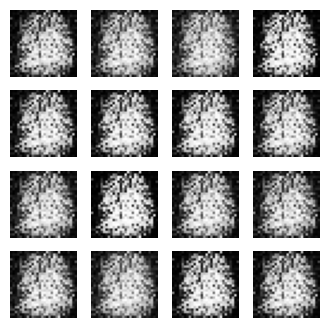

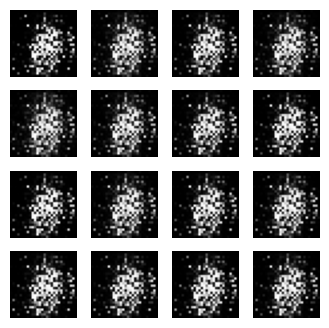

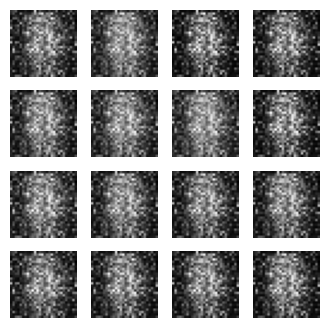

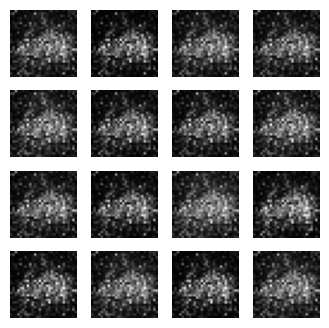

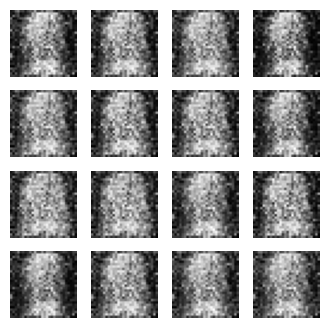

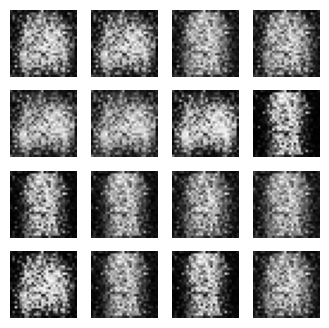

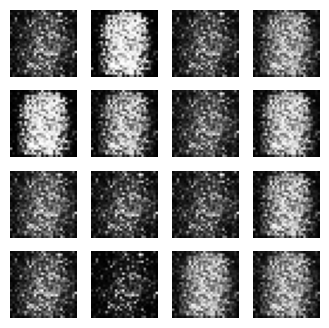

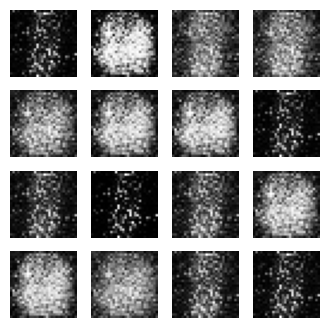

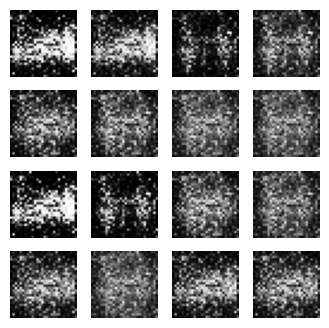

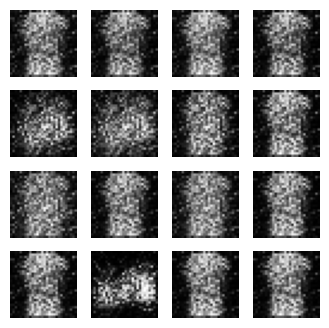

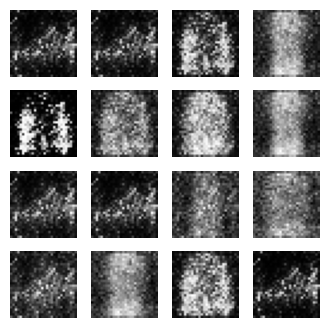

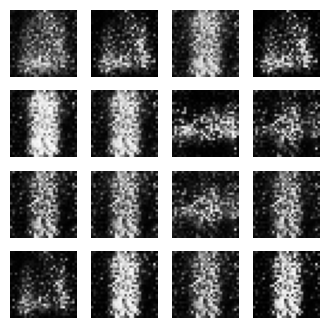

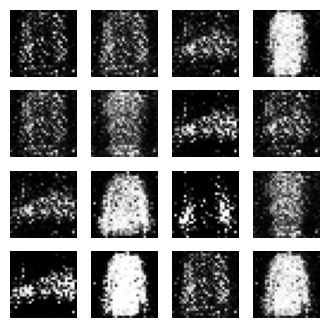

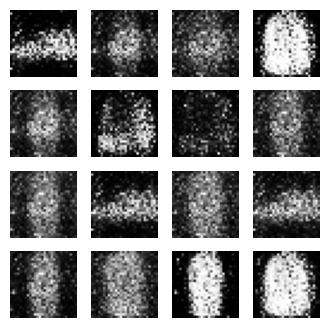

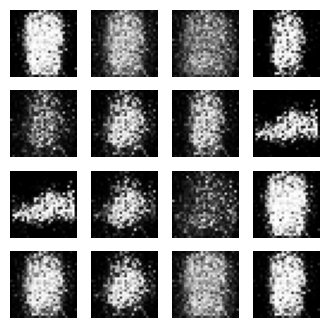

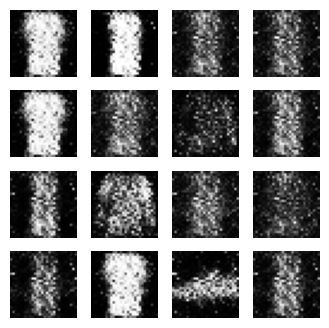

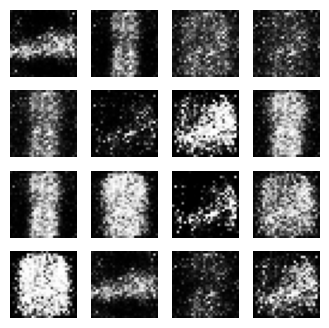

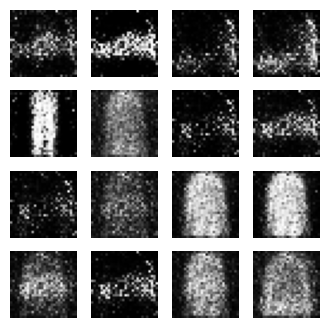

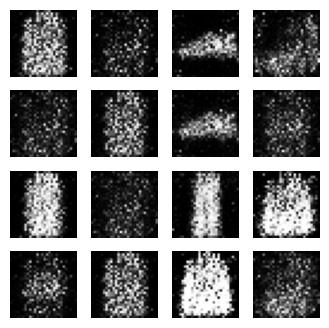

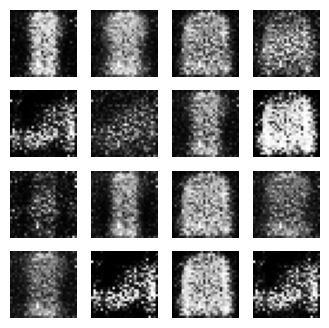

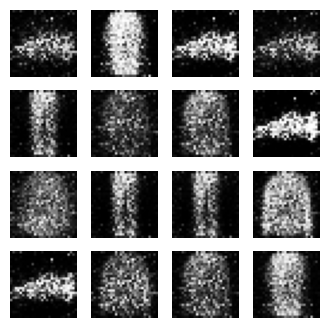

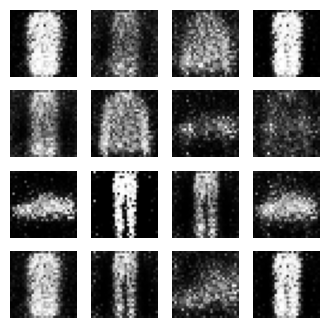

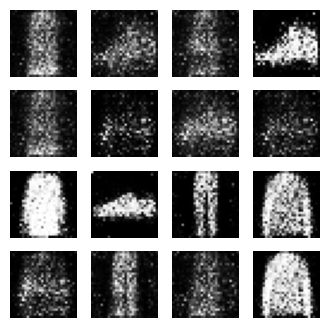

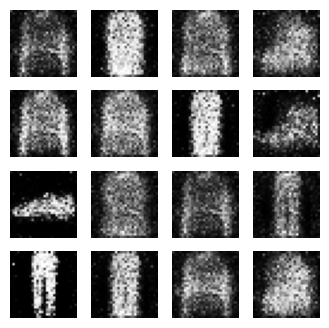

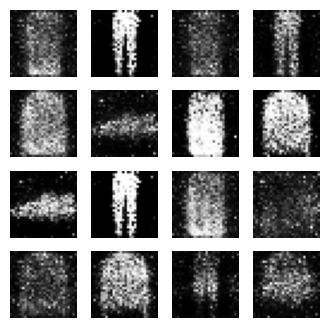

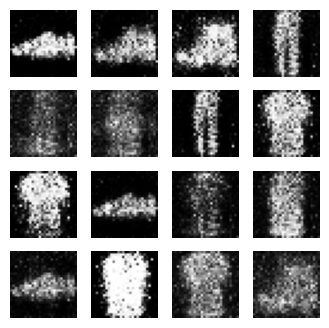

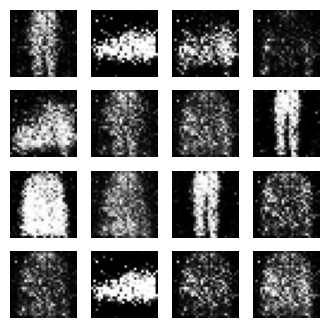

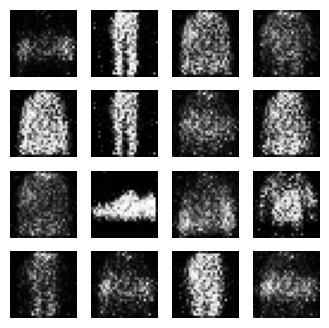

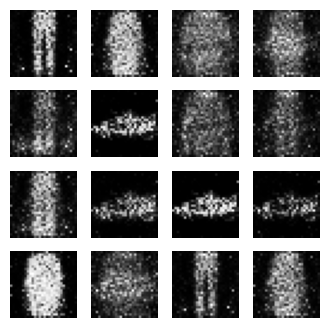

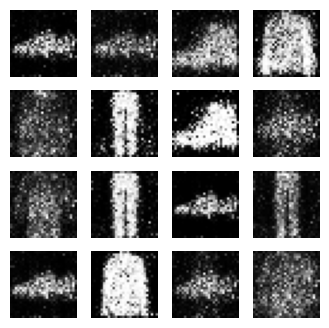

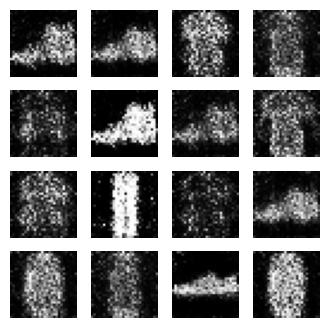

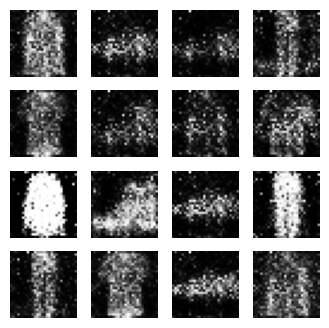

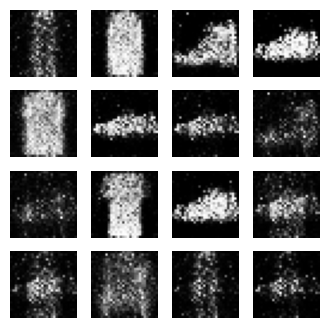

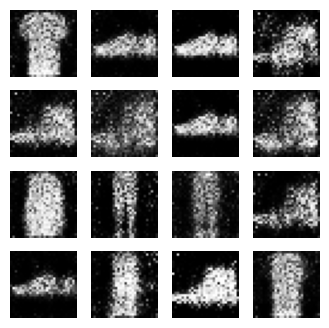

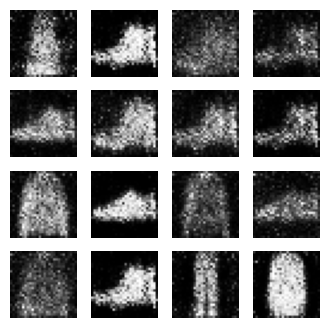

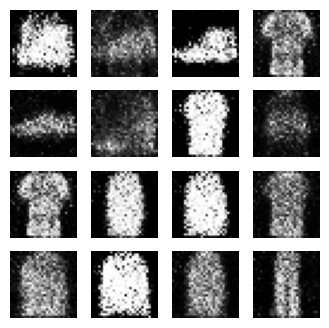

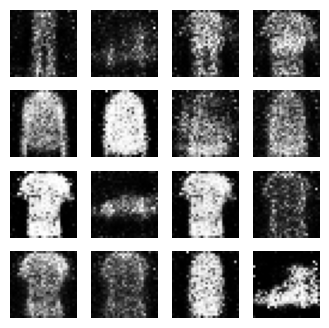

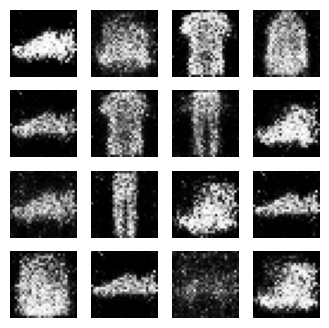

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Завантаження датасету Fashion MNIST
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train - 127.5) / 127.5  
x_train = np.expand_dims(x_train, axis=-1)

buffer_size = 60000
batch_size = 256

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

# Визначення генератора
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, activation="relu", input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28*1, activation="tanh"))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()

# Визначення дискримінатора
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=[28, 28, 1]))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Побудова GAN
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        noise = tf.random.normal([batch_size, 100])
        # Генерація фейкових зображень
        generated_images = self.generator(noise)
        # Комбінування реальних і фейкових міток
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))
        
        # Тренування дискримінатора
        with tf.GradientTape() as d_tape:
            real_output = self.discriminator(data)
            fake_output = self.discriminator(generated_images)

            d_loss_real = self.loss_fn(real_labels, real_output)
            d_loss_fake = self.loss_fn(fake_labels, fake_output)
            d_loss = d_loss_real + d_loss_fake

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        
        # Тренування генератора
        with tf.GradientTape() as g_tape:
            fake_output = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(real_labels, fake_output)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# Ініціалізація GAN
gan = GAN(generator, discriminator)
loss_fn = tf.keras.losses.BinaryCrossentropy()

gan.compile(
    g_optimizer=tf.keras.optimizers.Adam(1e-4),
    d_optimizer=tf.keras.optimizers.Adam(1e-4),
    loss_fn=loss_fn
)

# Тренування GAN
EPOCHS = 50
for epoch in range(EPOCHS):
    for batch in dataset:
        gan.train_step(batch)
    # Генерація зображень після кожної епохи, що б бачити прогрес
    noise = tf.random.normal([16, 100])
    generated_images = generator(noise)
    fig = plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    plt.show()
